In [2]:
from pathlib import Path
from PIL import Image

import numpy as np
import torch
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from IPython.display import clear_output

In [5]:
!unzip drive/MyDrive/mask_rcnn_dataset.zip
clear_output()

## Designing dataset

In [6]:
class AvoCavoDataset(torch.utils.data.Dataset):
    '''Our implementation of Dataset for training mask rcnn'''

    def __init__(self, data_dir, transforms=None):
        '''getting the list of files '''

        self.data_dir = data_dir     # saving the original directory of dataset
        self.transforms = transforms # saving the transf

        # getting paths to masks and images
        self.images_paths = list(map(str, Path(self.data_dir).rglob('*.jpg')) )

    def __getitem__(self, idx):

        # getting the paths of image and mask for it
        image_path = self.images_paths[idx]
        image_idx  = image_path.split('/')[-1].split('.')[0]
        mask_path  = f"{self.data_dir}/masks/{image_idx}.png"

        # get label for picture; Avocado = 1; Cava = 2
        label = int(image_path.split('/')[-2] == 'cava') + 1

        # opening image and mask
        image = Image.open(image_path).convert("RGB")
        mask  = Image.open(mask_path)

        # resizing it to a smaller resolution
        image = torchvision.transforms.Resize((1008, 756))(image)
        mask  = torchvision.transforms.Resize((1008, 756))(mask)

        # convert mask into a numpy array and removing the background
        mask = np.array(mask)
        mask[mask > 0] = 1

        # obtaining bounding box
        pos   = np.where(mask > 0)
        x_min = np.min(pos[1])
        x_max = np.max(pos[1])
        y_min = np.min(pos[0])
        y_max = np.max(pos[0])
        box   = [x_min, y_min, x_max, y_max]

        # tensorify everything
        label    = torch.as_tensor([label], dtype=torch.int64)
        box      = torch.as_tensor([box],   dtype=torch.float32)
        mask     = torch.as_tensor([mask], dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area     = (box[:, 3] - box[:, 1]) * (box[:, 2] - box[:, 0])
        iscrowd  = torch.zeros((1,), dtype=torch.int64)

        # filling the target instance
        target = {}
        target["boxes"]    = box
        target["labels"]   = label
        target["masks"]    = mask
        target["image_id"] = image_id
        target["area"]     = area
        target["iscrowd"]  = iscrowd

        # transforming if needed
        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.images_paths)

## Getting MASK RCNN model

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## Preparing data

In [8]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
# git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
# import torchvision.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # transforms.append(torchvision.transforms.Resize((756, 1008)))
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomPhotometricDistort(0.5))
        transforms.append(T.RandomZoomOut(0.5))
    return T.Compose(transforms)

In [10]:
# train and test datasets
dataset_dir  = 'mask_rcnn_dataset'
dataset      = AvoCavoDataset(dataset_dir, get_transform(train=True))
dataset_test = AvoCavoDataset(dataset_dir, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
test_samples = 10
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-test_samples])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_samples:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True,
                                          num_workers=4, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False,
                                               num_workers=4, collate_fn=utils.collate_fn)

## Training

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3,
                            momentum=0.9, weight_decay=0.0005)

# # and a learning rate scheduler which decreases the learning rate by
# # 10x every 3 epochs
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

In [30]:
num_epochs = 30

model.train()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # # update the learning rate
    # lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/44]  eta: 0:02:23  lr: 0.000024  loss: 4.4582 (4.4582)  loss_classifier: 1.2261 (1.2261)  loss_box_reg: 0.1814 (0.1814)  loss_mask: 3.0352 (3.0352)  loss_objectness: 0.0140 (0.0140)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 3.2660  data: 2.8125  max mem: 2485
Epoch: [0]  [10/44]  eta: 0:00:26  lr: 0.000257  loss: 2.6853 (2.9340)  loss_classifier: 0.9108 (0.9000)  loss_box_reg: 0.1793 (0.1753)  loss_mask: 1.5846 (1.8467)  loss_objectness: 0.0115 (0.0100)  loss_rpn_box_reg: 0.0015 (0.0020)  time: 0.7880  data: 0.3865  max mem: 2907
Epoch: [0]  [20/44]  eta: 0:00:16  lr: 0.000489  loss: 1.8359 (2.3484)  loss_classifier: 0.2871 (0.5615)  loss_box_reg: 0.1750 (0.1733)  loss_mask: 1.1433 (1.6017)  loss_objectness: 0.0057 (0.0088)  loss_rpn_box_reg: 0.0017 (0.0031)  time: 0.5650  data: 0.1712  max mem: 2907
Epoch: [0]  [30/44]  eta: 0:00:08  lr: 0.000721  loss: 1.0853 (1.9180)  loss_classifier: 0.1478 (0.4220)  loss_box_reg: 0.1466 (0.1604)  loss_mask: 0.8530 (1.3246)  loss_ob

KeyboardInterrupt: ignored

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

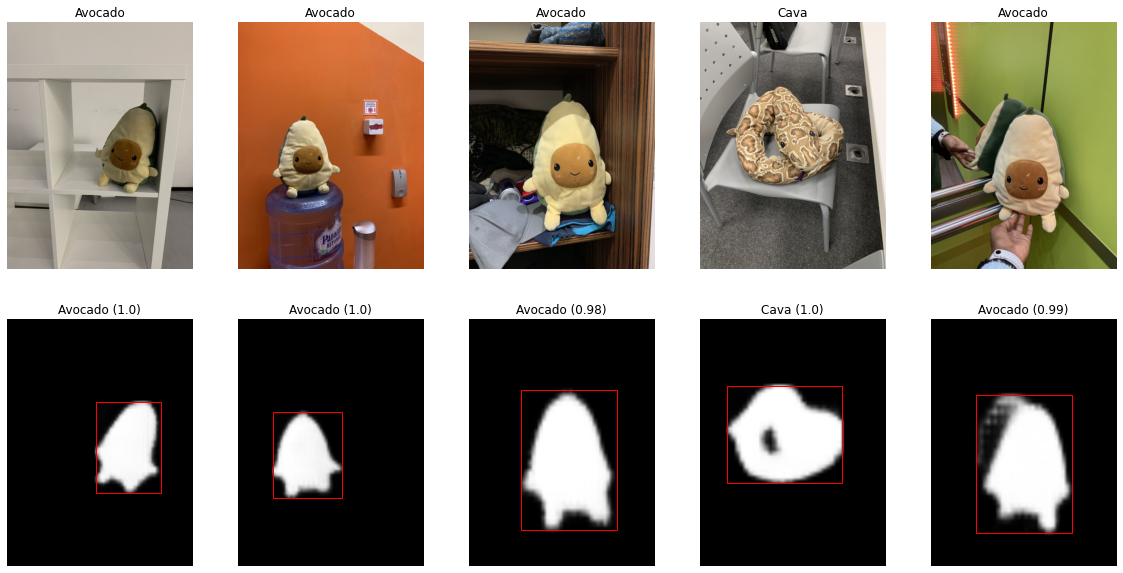

In [37]:
# putting model in evaluation mode
model.eval()

# setting up figure and plotting details
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# going and plotting the masks with labels and boxes
for i in range(5):

    # getting the data from test sampels
    image, target = dataset_test[i]

    # transform and get the true label
    true_label = 'Cava' if target['labels'][0].item() == 2 else 'Avocado'

    # propogating the data
    with torch.no_grad():
        prediction = model([image.to(device)])

    # getting the attributes of most confident object
    image = image.mul(255).permute(1, 2, 0).byte().numpy()
    box   = prediction[0]['boxes'][0].cpu().numpy()
    label = 'Cava' if prediction[0]['labels'][0].cpu().numpy() == 2 else 'Avocado'
    mask  = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
    score = prediction[0]['scores'][0].cpu().numpy()

    # plot image
    ax[0, i].axis('off')
    ax[0, i].set_title(true_label)
    ax[0, i].imshow(image)

    # obtaining rectangle for bounding box
    x_min, y_min, x_max, y_max = box
    bounding_box = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='none')

    # drawing mask, score and bounding box
    ax[1, i].axis('off')
    ax[1, i].set_title(f'{label} ({round(score.item(), 2)})')
    ax[1, i].imshow(mask, cmap='gray')
    ax[1, i].add_patch(bounding_box)

plt.show()